## Importacion liberias

In [1]:
!pip install torch numpy pandas matplotlib scikit-learn transformers datasets torcheval accelerate

In [1]:
import torch.nn as nn
import torch
#from torch.utils.data import Dataset, DataLoader
import os
import sys
import json
import numpy as np
import pandas as pd
import datasets as ds
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, EarlyStoppingCallback
)
from transformers.integrations import TensorBoardCallback
from transformers import EvalPrediction
from sklearn.metrics import f1_score, recall_score, precision_score
from torcheval.metrics import MulticlassAccuracy
from typing import Dict, List, Tuple, Union
from datasets import DatasetDict, load_dataset
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding

c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)

c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Scripts\python.exe


## Versiones, sys info, device ...

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(torch.cuda.get_arch_list())

# sys, library info
print("Operating System:", os.name)
print("Platform:", sys.platform)
print("Current Working Directory:", os.getcwd())
print("Environment Variables:", os.environ)
print("Python Version:", sys.version)
print("Command-line arguments:", sys.argv)
print(ds.__version__)

PyTorch version: 2.3.0+cu118
CUDA available: True
CUDA version: 11.8
Device name: NVIDIA RTX A500 Laptop GPU
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
Operating System: nt
Platform: win32
Current Working Directory: c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo
Environment Variables: environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\Jorge\\AppData\\Roaming', 'APPLICATION_INSIGHTS_NO_DIAGNOSTIC_CHANNEL': '1', 'BRB': 'C:\\Program Files\\HP\\Sure Click\\bin', 'BRS': 'C:\\Program Files\\HP\\Sure Click\\servers', 'CHROME_CRASHPAD_PIPE_NAME': '\\\\.\\pipe\\crashpad_26392_BGCXEYVHWWEQFZSG', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'KOKE00', 'COMSPEC': 'C:\\windows\\system32\\cmd.exe', 'CUDA_PATH': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.5', 'CUDA_P

In [4]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [7]:
torch.cuda.empty_cache()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **EDA**

In [9]:
# Importacion de Eda en colab
ruta_modulo_vis_colab = "/content/drive/MyDrive/NLP/code/"
sys.path.append(os.path.abspath(ruta_modulo_vis_colab))
from visualization import Eda

ModuleNotFoundError: No module named 'visualization'

In [10]:
# Importacion de Eda en local
sys.path.append(os.path.abspath('./code'))
from visualization import Eda

In [11]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [12]:
ruta_data_colab  = "/content/drive/MyDrive/NLP/data/data_tw.csv"
ruta_data_local = "./data/data_tw.csv"
ruta_data_kaggle = "/kaggle/input/data-tw/data_tw.csv"

df = pd.read_csv(ruta_data_local)
df.drop(columns = 	'Unnamed: 0', inplace = True)

In [13]:
df.head()

,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [14]:
df["label"].value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

In [15]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label'],
      dtype='object')

In [16]:
df.shape

(20000, 10)

In [17]:
# fecha post
df["post_created"].value_counts()

post_created
Sun Jan 08 06:00:47 +0000 2017    6
Sat May 02 21:15:55 +0000 2015    5
Thu Apr 30 12:18:52 +0000 2015    5
Tue Apr 21 10:15:28 +0000 2015    4
Sat Dec 31 14:12:17 +0000 2016    4
                                 ..
Fri Aug 28 12:24:54 +0000 2009    1
Fri Aug 28 12:56:23 +0000 2009    1
Fri Aug 28 12:56:36 +0000 2009    1
Fri Aug 28 14:08:16 +0000 2009    1
Thu Jan 12 00:04:47 +0000 2017    1
Name: count, Length: 19102, dtype: int64

In [18]:
# fechas unicas existentes [ver si post dedlos tweets repiten en mismas fechas]
df["post_created"].nunique()

19102

In [19]:
proporcion_fechas_unicas = df["post_created"].value_counts() / df["post_created"].nunique()

In [20]:
proporcion_fechas_unicas

post_created
Sun Jan 08 06:00:47 +0000 2017    0.000314
Sat May 02 21:15:55 +0000 2015    0.000262
Thu Apr 30 12:18:52 +0000 2015    0.000262
Tue Apr 21 10:15:28 +0000 2015    0.000209
Sat Dec 31 14:12:17 +0000 2016    0.000209
                                    ...   
Fri Aug 28 12:24:54 +0000 2009    0.000052
Fri Aug 28 12:56:23 +0000 2009    0.000052
Fri Aug 28 12:56:36 +0000 2009    0.000052
Fri Aug 28 14:08:16 +0000 2009    0.000052
Thu Jan 12 00:04:47 +0000 2017    0.000052
Name: count, Length: 19102, dtype: float64

In [85]:
labels = df['label'].unique()

In [86]:
labels

array([1, 0], dtype=int64)

**Antes de nada se van a crear de nuevas columnas de año,mes,dia,hora ... a apartir de fecha publicacion del post para anallizar mejor los datos**

In [21]:
def extract_date_components(date_string):
    format_string = "%a %b %d %H:%M:%S %z %Y"
    dt = datetime.strptime(date_string, format_string)
    return pd.Series({
        'dia': str(dt.day),
        'mes': str(dt.month),
        'año': str(dt.year),
        'h': dt.hour,
        'min': dt.minute,
        'seg': dt.second,
        'dia_semana': dt.strftime("%A"),
        'nombre_mes': dt.strftime("%B")
    })
date_components_df = df['post_created'].apply(extract_date_components)
df = pd.concat([df, date_components_df], axis=1)

In [22]:
df.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes',
       'año', 'h', 'min', 'seg', 'dia_semana', 'nombre_mes'],
      dtype='object')

In [23]:
df.head()

,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label,dia,mes,año,h,min,seg,dia_semana,nombre_mes
0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1,30,8,2015,7,48,37,Sunday,August
1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1,30,8,2015,7,31,33,Sunday,August
2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1,29,8,2015,22,11,7,Saturday,August
3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1,29,8,2015,18,40,49,Saturday,August
4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1,29,8,2015,18,40,26,Saturday,August


In [89]:
tw_eda = Eda(data = df, auto_eda = False, target_var  = "label")

In [90]:
# Columnas categoricas del df
tw_eda.cat_cols

['post_created', 'post_text', 'dia', 'mes', 'año', 'dia_semana', 'nombre_mes']

In [73]:
# Columnas categoricas del df
tw_eda.num_cols

['post_id',
 'user_id',
 'followers',
 'friends',
 'favourites',
 'statuses',
 'retweets',
 'label',
 'dia',
 'mes',
 'año',
 'h',
 'min',
 'seg',
 'maped_labels']

In [ ]:
# Columnas numericas del df
tw_eda.infonum

####  **Antes de empezar con las graficas y debido a las diferentes escalas de las variables numericas se estandarizan estas y se dropean el user_id, label , el post_id ... para ue no se vean afectadas por la estandarizacion [resta la media y divide entre la varianza de cada feature por separado]**

In [ ]:
num_data_clean = tw_eda.num_data.drop(columns = ["user_id","post_id",'label','año','mes','dia','h','min','seg'])

In [ ]:
num_data_clean.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std_data = std.fit_transform(num_data_clean)
std_dataframe = pd.DataFrame(data = std_data ,columns = num_data_clean.columns.tolist())
tw_eda_std = Eda(data = std_dataframe)

In [ ]:
# Exploramos el cambio de escala aplicado
tw_eda_std.infonum

In [ ]:
# Histogramas de las vraiables numericas
tw_eda.plot_hist(
                        bins = 30 ,
                        divide_feature = None,
                        layout = 'constrained',
                        fig_x_size = 10 ,
                        fig_y_size = 6,
                        fig_rows = 1 ,
                        fig_cols = 2 ,
                        linewidth = 0.5 ,
                        density = True,
                        stacked = True
                      )

In [ ]:
# Diagramas de barras
tw_eda.plot_bar(
            layout = 'constrained',
            rotation = 0 ,
            fig_x_size = 16,
            fig_y_size = 6,
            fig_rows = 1,
            fig_cols = 2 ,
            plot_limit_categories = 20
         )

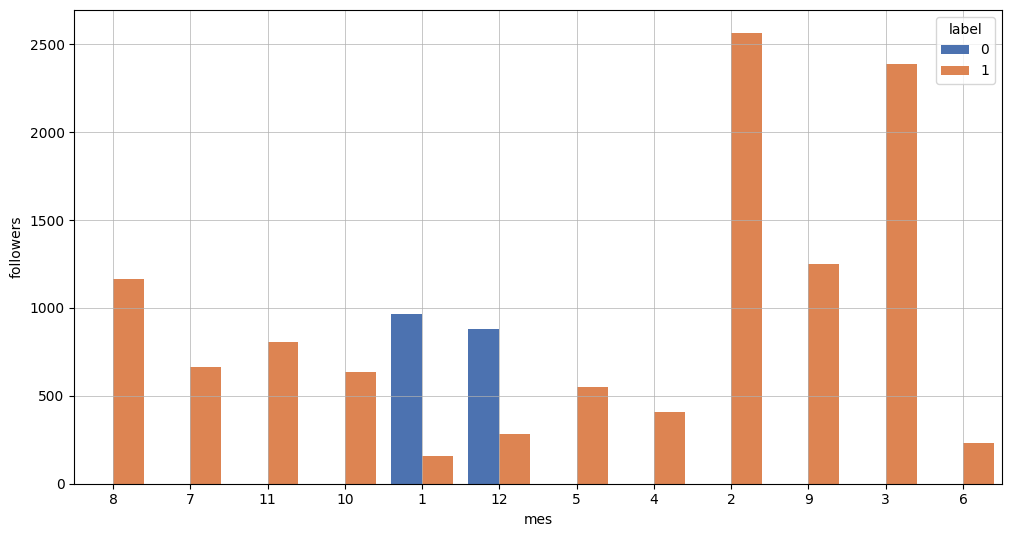

In [94]:
# Diagramas de barras combinados
tw_eda.plot_combined_bar(
                                layout = 'constrained',
                                fig_x_size = 10,
                                fig_cols = 1,
                                value_feature =  'followers',
                                target_feature = 'mes',
                                max_categories = 10,
                                divide_feature = "label",
                                errorbar = None,
                                estimator = np.mean, # Estimator puede ser un callable (es decir funcion) np.mean, np.sum o 'sum', ... funciones de numpy que se apliquen a un vector
                                                    # np.mean te hace la media de todo el vestor y te la plotea en el eje y
                                                    # np.sum te suma todo el vector y te lo plotea en el eje y
                                color = 0,
                                )

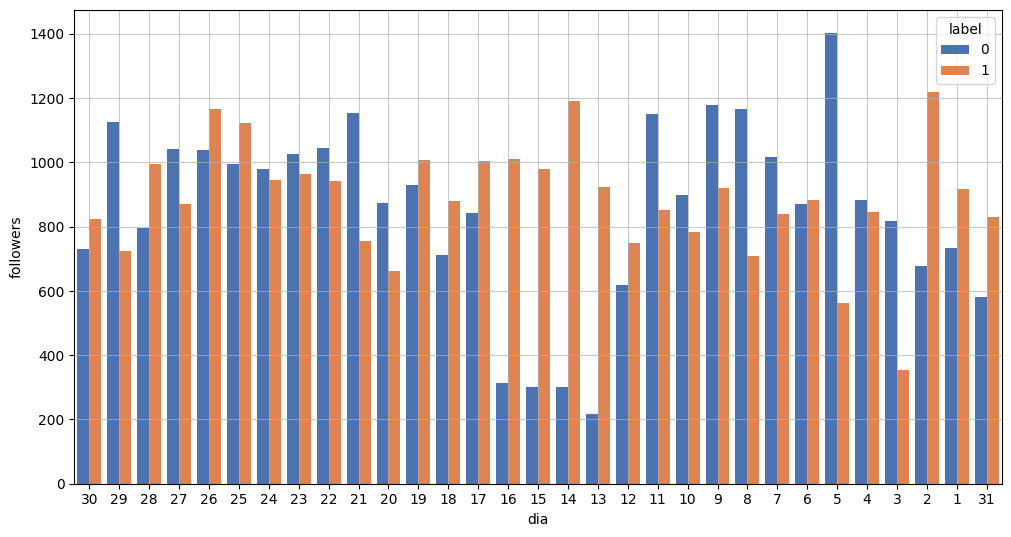

In [95]:
# Diagramas de barras combinados
tw_eda.plot_combined_bar(
                                layout = 'constrained',
                                fig_x_size = 10,
                                fig_cols = 1,
                                value_feature =  'followers',
                                target_feature = 'dia',
                                max_categories = 10,
                                divide_feature = "label",
                                errorbar = None,
                                estimator = np.mean, # Estimator puede ser un callable (es decir funcion) np.mean, np.sum o 'sum', ... funciones de numpy que se apliquen a un vector
                                                    # np.mean te hace la media de todo el vestor y te la plotea en el eje y
                                                    # np.sum te suma todo el vector y te lo plotea en el eje y
                                color = 0,
                                )

In [69]:
## Probamos a contar con cuantos registros nos quedariamos si quitasemos de los meses que no sean january y dec porque esos meses no tienen la label 1
df_ = tw_eda.data[(tw_eda.data["nombre_mes"] == 'January') | (tw_eda.data["nombre_mes"] == 'December')]
df_.shape[0]

12323

In [70]:
tw_eda.data.shape[0]

20000

In [71]:
# En el caso de prescinidr de los demas meses perderiamos este numero de registros [evaluar despues solo con estos registros]
solo_jan_dec = tw_eda.data.shape[0] -df_.shape[0]
solo_jan_dec

7677

In [ ]:
# mapa de calor de la matriz de correlacion (coeficientes de pearson entre cada par de features numericas)
tw_eda_std.plot_corr_heatmap(
                                fig_x_size = 10,
                                fig_y_size = 8,
                                layout = 'constrained' ,
                                linewidth = 0.5,
                                cmap = 'coolwarm', # 'Set1', 'Set2', 'Set3', 'Paired','Accent', 'Prism', 'Dark2','Paired', 'coolwarm', 'viridis', 'cubehelix'
                                annot = True, # If True, plot el valor numerico de corrrelacion (entre variables) en la celda del mapa de calor
                                fmt = '.2f' # Especificacion del formato numerico

                                )

#### **apenas hay correlacion, excepto por el numero de followers y el numero de friends que estan positivamente realcionadas, si una aumenta la otra tambien. Podria prescdindir de una de ellas para la prediccion**

In [ ]:
# mapa de calor de la matriz de correlacion (coeficientes de pearson entre cada par de features numericas)
tw_eda.plot_corr_heatmap(
                                fig_x_size = 10,
                                fig_y_size = 8,
                                layout = 'constrained' ,
                                linewidth = 0.5,
                                cmap = 'coolwarm', # 'Set1', 'Set2', 'Set3', 'Paired','Accent', 'Prism', 'Dark2','Paired', 'coolwarm', 'viridis', 'cubehelix'
                                annot = True, # If True, plot el valor numerico de corrrelacion (entre variables) en la celda del mapa de calor
                                fmt = '.2f' # Especificacion del formato numerico

                                )

#### **en el caso del dataset sin estandarizar ni dropear columnas, la variable target esta negativamente relacionada con el id del tweet, los tweets clasificados como 1 tendran menores valores del id del post**

In [ ]:
# Scatter plot contra labels
tw_eda_std.plot_scatter(
                            fig_x_size = 14,
                            fig_cols = 2,
                            linewidth =  0.5,
                            layout = 'constrained' ,
                            x =   ['followers','friends', 'favourites', 'statuses', 'retweets'],
                            y = ["friends"],
                            size = "retweets",
                            hue = "favourites",
                            color = 0,
                            plotting_lib = 'plotly',
                            umbral = 5,
                            show_outliers = False,
                            plotly_opacity = 0.6,
                            plotly_colorscale = 20, #[19,20,21,22,23,24]
                            plotly_bgcolor = None ,# str or none
                            save_figure = None, #["jpeg","png","WebP",None]
                            name_figure = "Fig"
                            )

## **Preprocesamiento**

In [ ]:
tw_eda.data.columns

#### **Duplicados**

#### Numero de registros duplicados

In [ ]:
# Numero de registros duplicados : mismoss valores de cada campo en toda la fila == son el mismo registro -> drop de esas filas
duplicated_registers = tw_eda.data.duplicated()

In [ ]:
duplicated_registers.sum()

In [ ]:
duplicated_registers_df = tw_eda.data[duplicated_registers]
duplicated_registers_df.head()

Hay 117 filas iguales, se proceden a eliminar

In [ ]:
tw_eda_no_d = tw_eda.data.drop_duplicates(keep='first', inplace=False, ignore_index=False)

In [ ]:
tw_eda_no_d.duplicated().sum()

#### Numero de tweets iguales

In [ ]:
duplicated_texts = tw_eda_no_d.duplicated(subset=['post_text'])

In [ ]:
duplicated_texts.sum()

Hay 395 tweets iguales, se proceden a evaluar sus demas campos: ids, fecha post,...

In [ ]:
duplicate_text_df = tw_eda.data[duplicated_texts]
tw_duplicated_eda = Eda(data =duplicate_text_df)
tw_duplicated_eda.data.head()

In [ ]:
# numero de user_id diferentes en los twweets repetidos
tw_duplicated_eda.data['user_id'].unique()

In [ ]:
# textos repetidos
tw_duplicated_eda.data['post_text'].unique()

In [ ]:
# user_id [numerica] -> user_id_cat [categorica]
import string
uppercase_letters = list(string.ascii_uppercase)  # lista de letras de 'A' a 'Z' usando el módulo string
print(uppercase_letters)
map_user = {user_id:f'user_{letter}' for letter,user_id in zip(uppercase_letters,tw_duplicated_eda.data['user_id'].unique())}
tw_duplicated_eda.data['user_id_cat'] = tw_duplicated_eda.data['user_id'].map(map_user)
tw_duplicated_eda = Eda(data=tw_duplicated_eda.data)

In [ ]:
tw_duplicated_eda.data.head()

In [ ]:
# Diagramas de barras
tw_duplicated_eda.plot_bar(
            layout = 'constrained',
            rotation = 0 ,
            fig_x_size = 16,
            fig_y_size = 6,
            fig_rows = 1,
            fig_cols = 2 ,
            plot_limit_categories = 20
         )

In [ ]:
user_h = tw_duplicated_eda.data[tw_duplicated_eda.data['user_id_cat'] == 'user_H']
print(user_h['post_text'].head(10))

#### **Manejo/limpieza de caracteres especiales [no aportan significado]**

In [ ]:
tw_eda.data.columns

) missing from font(s) DejaVu Sans.P\trabajo\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8 ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


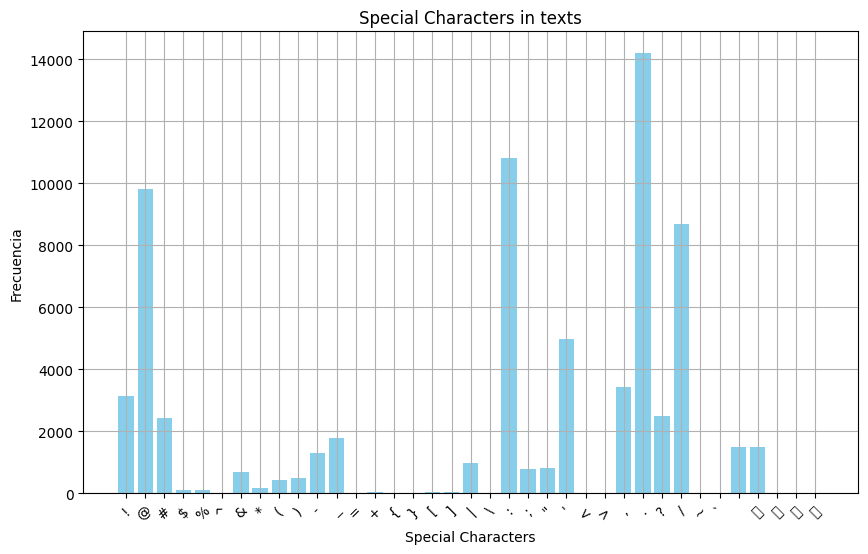

0        It's just over 2 years since I was diagnosed w...
1        It's Sunday, I need a break, so I'm planning t...
2        Awake but tired. I need to sleep but my brain ...
3        RT @SewHQ: #Retro bears make perfect gifts and...
4        It’s hard to say whether packing lists are mak...
                               ...                        
19995                A day without sunshine is like night.
19996    Boren's Laws: (1) When in charge, ponder. (2) ...
19997    The flow chart is a most thoroughly oversold p...
19998    Ships are safe in harbor, but they were never ...
19999       Black holes are where God is dividing by zero.
Name: post_text, Length: 20000, dtype: object


In [25]:
import re
def count_special_caracters(special_c : List[str], data : pd.DataFrame, text_field_name :str, delete :bool =False, plot : bool =False):
    df = data.copy()
    special_c_count = {}
    count = 0
    for c in special_c:
        count = 0
        patron_busqueda = re.compile(re.escape(c))
        for i in range(df.shape[0]):
            match_obj = patron_busqueda.search(df.loc[i,text_field_name])
            if c in df.loc[i,text_field_name] or match_obj is not None:
                count += 1
                if delete:
                    text = df.loc[i,text_field_name]
                    clean_text = text.replace(c,'')
                    clean_text = df.loc[i,text_field_name]
            special_c_count[c] = count
    if plot:
        plt.figure(figsize=(10, 6))
        plt.bar(special_c_count.keys(), special_c_count.values(), color='skyblue')
        plt.xlabel('Special Characters')
        plt.ylabel('Frecuencia')
        plt.title('Special Characters in texts')
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()

    return special_c_count, df

special_characters = [
    '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '=', '+',
    '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.',
    '?', '/', '~', '`', '\n', '\r', '\t', '\b', '\f'
]

special_c,df_clean = count_special_caracters(
                                          special_c  = special_characters,
                                          data = df,
                                          text_field_name = 'post_text',
                                          delete=False,
                                          plot=True
                                            )

print( df["post_text"])

In [26]:
special_c,df_clean = count_special_caracters(special_characters, df_clean, 'post_text', delete=True, plot=False)

# INTENTO CON DEBERTA Y LIB TRANSFORMERS Y DATASETS DE HG

## Creacion dataset de entrenamiento [HG Dataset]

In [27]:
# util functions
def get_current_utc_date_iso():
    # Get the current date and time in UTC and format it directly
    return datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S")

In [28]:
class TwDataset:
  def __init__(self, tokenizer,padding, truncate, max_position_embeddings, df, text_field_name, label_field_name, id_field_name):
    self.tokenizer = tokenizer
    self.padding = padding
    self.truncate = truncate
    self.max_length = max_position_embeddings
    self.data = df
    try:
      self.labels = df[label_field_name].unique()
    except Exception as e:
      print(e)
    self.label2id = {l:i for i,l in enumerate(self.labels)}
    self.id2label = {i:l for i,l in enumerate(self.labels)}
    self.text_f_name = text_field_name
    self.label_f_name = label_field_name
    if id_field_name:
      self.id_field_name = id_field_name
      self.ids = {k:[] for k in id_field_name}
      print('ID FIELDS :',self.ids)
    self.tokens = []
    self.len_texts = []


  def _tokenize_texts(self, texts : List[str], tensor :bool = False):
    if isinstance(texts , list):
      if self.tokenizer is not None:
        if tensor:
          x = self.tokenizer(texts,  padding=self.padding, truncation=self.truncate,  max_length =self.max_length, return_tensors="pt")
        else:
          x = self.tokenizer(texts, padding=self.padding, truncation=self.truncate, max_length =self.max_length)
        return x
      else:
        raise ValueError('No tokenizer passed as argument')


  def _process_dataset(self, dataset) -> dict:
      text_name_field = self.text_f_name if isinstance(self.text_f_name, str) else None
      if text_name_field is None:
          raise AttributeError("Text field name must be str")

      text = str(dataset[text_name_field]) # aseguramos tipo de dato es str

      # tokenizacion
      #tokenized = self.tokenizer(text, padding=True, truncation=True, ,max_lenght =512 )
      tokenized = self.tokenizer(text,padding=self.padding, truncation=self.truncate, max_length =self.max_length)

      # calculo de tokens , caracteres y ids por texto
      self.tokens.append(len(tokenized["input_ids"]))
      self.len_texts.append(len(text))
      for id_i in self.ids.keys():
        self.ids[id_i].append(dataset[id_i])

      # labels
      tokenized["labels"] = dataset[self.label_f_name]

      return tokenized


  def get_hg_dataset(self, split : bool = False, tokenize :bool = True, from_csv: bool =False, csv_path :str = None ):

      # load original dataset from path
      if from_csv:
        try:
          dataset = load_dataset("csv", data_files=csv_path, split = 'train')
          try:
            dataset = dataset.remove_columns(["Unnamed: 0"])
          except:
            pass
          print(dataset)
        except Exception as e:
            print(e)
        if split:
          dataset_train_test = dataset.train_test_split(test_size = 0.2, shuffle = True, seed =42)
          dataset_train_val = dataset_train_test["train"].train_test_split(test_size = 0.1, shuffle = True, seed =42)
          dataset = DatasetDict({
                                                  "train": dataset_train_val["train"],
                                                  "validation": dataset_train_val["test"],
                                                  "test":dataset_train_test["test"]
                                                  })
      else:
        try:
            if split:
                # test 20 % train
                df_train_val, df_test = train_test_split(self.data, test_size=0.2, random_state=42)
                print('\n---------------------------------------------------')
                print("Test df shape : ", df_test.shape)
                # Validation 10% de train
                df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42)
                print("Train df shape : ", df_train.shape)
                print("validation df shape : ", df_val.shape)
                print('---------------------------------------------------\n')


                dataset = DatasetDict({
                                                    "train": ds.Dataset.from_pandas(df_train, preserve_index=False),
                                                    "validation": ds.Dataset.from_pandas(df_val, preserve_index=False),
                                                    "test":ds.Dataset.from_pandas(df_test, preserve_index=False)
                                                    })
            else:
                dataset = DatasetDict({
                                    "train": ds.Dataset.from_pandas(self.data, preserve_index=False)
                                    })


            print("\nHG DATASET :\n ", dataset)
            #dataset = load_dataset(self.path).remove_columns(["Unnamed: 0"])
        except Exception as e:
            print(e)


      if tokenize:
          dataset_tokenize = dataset.map(self._process_dataset, batched=False, remove_columns=self.data.columns.tolist())
      else:
          dataset_tokenize = None
      print("\nHG DATASET TOKENIZE:\n ", dataset_tokenize)
      return dataset,dataset_tokenize

  def get_plots(self, dir_path: str, figure_name: str, show : bool = False):

      def addlabels(x, y, text, size, rotation):
          colors = ['g', 'r', 'c', 'm', 'y', 'k']  # Removed 'b' (blue) from the list
          c = 0
          for i in range(len(x)):
              if c >= len(colors):
                  c = 0
              plt.annotate(text[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center', size=size, color=colors[c], rotation=rotation)
              c += 1

      # Calculate the number of tokens for each document
      if self.tokens and self.len_texts:

          # Plotting the histogram of token counts
          plt.figure(figsize=(10, 6))
          plt.hist(self.tokens, bins=30, color="blue", edgecolor="black", alpha=0.7)
          plt.title("Histogram of Token Counts")
          plt.xlabel("Token Count")
          plt.ylabel("Frequency")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "token_hist.png")
            plt.savefig(plot_file)
            plt.close()

          # Plotting the histogram of characters counts
          plt.figure(figsize=(10, 6))
          plt.hist(self.len_texts, bins=30, color="red", edgecolor="black", alpha=0.7)
          plt.title("Histogram of Character Counts")
          plt.xlabel("Character Count")
          plt.ylabel("Frequency")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "character_hist.png")
            plt.savefig(plot_file)
            plt.close()

          # Plotting ordered chunk vs num tokens
          SAMPLE_PLOT_SIZE = min(100, len(self.len_texts))
          NUM_CHUNKS = np.arange(SAMPLE_PLOT_SIZE)

          plt.figure(figsize=(10, 6))
          plt.bar(NUM_CHUNKS, self.tokens[:SAMPLE_PLOT_SIZE], color="blue", alpha=1)
          addlabels(NUM_CHUNKS, self.tokens[:SAMPLE_PLOT_SIZE], [str(t) for t in self.tokens[:SAMPLE_PLOT_SIZE]], 10, 0)
          for i,id_i in enumerate(self.id_field_name):
              plot_id = []
              for v in self.ids[id_i][:SAMPLE_PLOT_SIZE]:
                  plot_id.append('#'+ str(id_i)+':'+str(v))
              addlabels(
                          x = NUM_CHUNKS,
                          y = np.full(len(self.tokens[:SAMPLE_PLOT_SIZE]), np.max(self.tokens[:SAMPLE_PLOT_SIZE]))*(0.1*(i+1)),
                          text = plot_id,
                          size = 6,
                          rotation = 40)
          plt.title("Token counts per chunk index")
          plt.xlabel("CHUNK index")
          plt.ylabel("Token counts")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "num_token_per_chunk.png")
            plt.savefig(plot_file)
            plt.close()

          plt.figure(figsize=(10, 6))
          plt.bar(NUM_CHUNKS, self.len_texts[:SAMPLE_PLOT_SIZE], color="red", alpha=1)
          addlabels(NUM_CHUNKS, self.len_texts[:SAMPLE_PLOT_SIZE], [str(t) for t in self.len_texts[:SAMPLE_PLOT_SIZE]], 10, 0)
          for i,id_i in enumerate(self.id_field_name):
              plot_id = []
              for v in self.ids[id_i][:SAMPLE_PLOT_SIZE]:
                  plot_id.append('#'+ str(id_i)+':'+str(v))
              addlabels(
                          x = NUM_CHUNKS,
                          y = np.full(len(self.len_texts[:SAMPLE_PLOT_SIZE]), np.max(self.tokens[:SAMPLE_PLOT_SIZE]))*(0.2*(i+1)),
                          text = plot_id,
                          size = 6,
                          rotation = 40)
          plt.title("Character counts per chunk index")
          plt.xlabel("CHUNK index")
          plt.ylabel("Character counts")
          plt.grid(axis="y", alpha=0.75)
          if show:
            plt.show()
          else:
            plot_file = os.path.join(dir_path, get_current_utc_date_iso() + "_" + figure_name + "_" + "num_character_per_chunk.png")
            plt.savefig(plot_file)
            plt.close()

In [62]:
# MODEL
from transformers import AutoModel, AutoModel, AutoConfig
from transformers import DebertaV2Config
CONFIG_DEBERTA_V2 = DebertaV2Config()

#MODEL_NAME = 'microsoft/deberta-v2-xlarge'
MODEL_NAME = 'microsoft/deberta-v3-base'


CONFIG_DEBERTA_V3 = AutoConfig.from_pretrained(
                                        pretrained_model_name_or_path =MODEL_NAME
                                        )
# Como deberta-v3 no tiene definido la maxima dimension de los embedding input 
# # y su configuracxion es similar a la de deberta-v2 que si lo tiene definido se lo copiamos ded su config 
CONFIG_DEBERTA_V3.max_position_embeddings= CONFIG_DEBERTA_V2.max_position_embeddings

"""no efecto en el tokenizer:
# Para que se haga efectivo en la confg del tokenizer tambnien hay que añadir una nueva key al modelo con el mismo valor:
CONFIG_DEBERTA_V3.max_model_input_sizes =CONFIG_DEBERTA_V2.max_position_embeddings
"""

model = AutoModel.from_pretrained(
                                        pretrained_model_name_or_path = MODEL_NAME,
                                        config = CONFIG_DEBERTA_V3)

tokenizer = AutoTokenizer.from_pretrained(  
                                          pretrained_model_name_or_path =MODEL_NAME,
                                          use_fast=True,
                                          model_max_length =CONFIG_DEBERTA_V3.max_position_embeddings
                                          )

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [63]:
# prueba tokenizer
tokenizer.encode(text = "holamdkmdkdmewkmdmdkdmdmkdmdkm2d",return_tensors='pt')

tensor([[    1, 36752,  1764,   407,  6275, 32921,   407,   358, 17326,  6275,
           407,   358, 32921,   407,   358,   407, 57493,   407,   358,   407,
          6275,   445,   407,     2]])

In [69]:
dir(CONFIG_DEBERTA_V3)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attn_implementation',
 '_attn_implementation_internal',
 '_auto_class',
 '_commit_hash',
 '_create_repo',
 '_dict_from_json_file',
 '_get_config_dict',
 '_get_files_timestamps',
 '_get_generation_defaults',
 '_has_non_default_generation_parameters',
 '_name_or_path',
 '_set_token_in_kwargs',
 '_upload_modified_files',
 'add_cross_attention',
 'architectures',
 'attention_probs_dropout_prob',
 'attribute_map',
 'bad_words_ids',
 'begin_suppress_tokens',
 'bos_token_id',
 'chunk_size_feed_forward',
 'cross_attention_hidden_size',
 'decoder_start_token_id',
 'dict_torch_dtype_to_str',


In [74]:
CONFIG_DEBERTA_V3_dict = CONFIG_DEBERTA_V3.to_json_string()

In [75]:
CONFIG_DEBERTA_V3_dict

'{\n  "_name_or_path": "microsoft/deberta-v3-base",\n  "attention_probs_dropout_prob": 0.1,\n  "hidden_act": "gelu",\n  "hidden_dropout_prob": 0.1,\n  "hidden_size": 768,\n  "initializer_range": 0.02,\n  "intermediate_size": 3072,\n  "layer_norm_eps": 1e-07,\n  "max_position_embeddings": 512,\n  "max_relative_positions": -1,\n  "model_type": "deberta-v2",\n  "norm_rel_ebd": "layer_norm",\n  "num_attention_heads": 12,\n  "num_hidden_layers": 12,\n  "pad_token_id": 0,\n  "pooler_dropout": 0,\n  "pooler_hidden_act": "gelu",\n  "pooler_hidden_size": 768,\n  "pos_att_type": [\n    "p2c",\n    "c2p"\n  ],\n  "position_biased_input": false,\n  "position_buckets": 256,\n  "relative_attention": true,\n  "share_att_key": true,\n  "transformers_version": "4.39.3",\n  "type_vocab_size": 0,\n  "vocab_size": 128100\n}\n'

In [84]:
CONFIG_DEBERTA_V3

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.39.3",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [66]:
CONFIG_DEBERTA_V2

DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 6144,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "num_attention_heads": 24,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1536,
  "pos_att_type": null,
  "position_biased_input": true,
  "relative_attention": false,
  "transformers_version": "4.39.3",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [ ]:
tokenizer

In [102]:
## Probamos a contar con cuantos registros nos quedariamos si quitasemos de los meses que no sean january y dec porque esos meses no tienen la label 1
df_jan_dec = df[(df["nombre_mes"] == 'January') | (df["nombre_mes"] == 'December')]
df_jan_dec.shape[0]

12323

In [104]:
df_jan_dec.columns

Index(['post_id', 'post_created', 'post_text', 'user_id', 'followers',
       'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes',
       'año', 'h', 'min', 'seg', 'dia_semana', 'nombre_mes'],
      dtype='object')

In [105]:
dataset = TwDataset(
                    tokenizer =tokenizer ,
                    padding = True,
                    truncate = True,
                    max_position_embeddings = CONFIG_DEBERTA_V3.max_position_embeddings,
                    df =df_jan_dec,
                    text_field_name = 'post_text',
                    label_field_name = 'label',
                    id_field_name = ['post_id']
                    )
ruta_data_colab = "/content/drive/MyDrive/NLP/data/data_tw.csv"
ruta_data_kaggle = "/kaggle/input/data-tw"
_, dataset_split = dataset.get_hg_dataset(split = True, tokenize = True, from_csv = False, csv_path = ruta_data_kaggle )

ID FIELDS : {'post_id': []}

---------------------------------------------------
Test df shape :  (2465, 18)
Train df shape :  (8872, 18)
validation df shape :  (986, 18)
---------------------------------------------------


HG DATASET :
  DatasetDict({
    train: Dataset({
        features: ['post_id', 'post_created', 'post_text', 'user_id', 'followers', 'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes', 'año', 'h', 'min', 'seg', 'dia_semana', 'nombre_mes'],
        num_rows: 8872
    })
    validation: Dataset({
        features: ['post_id', 'post_created', 'post_text', 'user_id', 'followers', 'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes', 'año', 'h', 'min', 'seg', 'dia_semana', 'nombre_mes'],
        num_rows: 986
    })
    test: Dataset({
        features: ['post_id', 'post_created', 'post_text', 'user_id', 'followers', 'friends', 'favourites', 'statuses', 'retweets', 'label', 'dia', 'mes', 'año', 'h', 'min', 'seg', 'dia_semana', 'nomb

Map:   0%|          | 0/8872 [00:00<?, ? examples/s]

Map:   0%|          | 0/986 [00:00<?, ? examples/s]

Map:   0%|          | 0/2465 [00:00<?, ? examples/s]


HG DATASET TOKENIZE:
  DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8872
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 986
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2465
    })
})


In [106]:
dataset_split["train"]["labels"][0:10]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

In [ ]:
ruta_fig_colab = '/content/drive/MyDrive/NLP/data'
ruta_fig_local = "/content/drive/MyDrive/NLP/data/figures"
dataset.get_plots(dir_path = ruta_fig_colab, figure_name = 'tw_fig', show = True)

### Clasifier class

#### Configuration for the classifier

In [109]:
FILE_PATH_CONF = './conf/model.json'
FILE_PATH_CONF_COLAB = '/content/drive/MyDrive/NLP/conf/model.json'
CHECK_POINT_PATH = "./model/checkpoint"
MODEL_SAVE_PATH = "./model"

CHECK_POINT_PATH_COLAB = "/content/drive/MyDrive/NLP/model"

# max_position_embeddings : The maximum sequence length that this model might ever be used with. Typically set this to something large just in case (e.g., 512 or 1024 or 2048).
MODEL_CONFG ={
  "model": {
              "name": MODEL_NAME,              
              "emergency_save_path": MODEL_SAVE_PATH+"/last_params",
              "config" : {
                            "_name_or_path": "microsoft/deberta-v3-base",
                              "attention_probs_dropout_prob": 0.1,
                              "hidden_act": "gelu",
                              "hidden_dropout_prob": 0.1,
                              "hidden_size": 768,
                              "initializer_range": 0.02,
                              "intermediate_size": 3072,
                              "layer_norm_eps": 1e-07,
                              "max_position_embeddings": 512,
                              "max_relative_positions": -1,
                              "model_type": "deberta-v2",
                              "norm_rel_ebd": "layer_norm",
                              "num_attention_heads": 12,
                              "num_hidden_layers": 12,
                              "pad_token_id": 0,
                              "pooler_dropout": 0,
                              "pooler_hidden_act": "gelu",
                              "pooler_hidden_size": 768,
                              "pos_att_type": [
                                "p2c",
                                "c2p"
                              ],
                              "position_biased_input": False,
                              "position_buckets": 256,
                              "relative_attention": True,
                              "share_att_key": True,
                              "transformers_version": "4.39.3",
                              "type_vocab_size": 0,
                              "vocab_size": 128100
                            }
              
          },
  "problem" : {
                "labels_to_pred" : [0,1]
  },
  "trainer":{
              "callbacks":{
                            "EarlyStoppingCallback": {
                                                        "early_stopping_patience":50,
                                                        "early_stopping_threshold":0.0
                                                      }
                          }
              },

  "metrics": {
              "type":
                    {
                    "f1": {"compute": True, "method": ["micro", "macro", "weighted","binary"]},
                    "recall": {"compute": True, "method": ["micro", "macro", "weighted","binary"]},
                    "MulticlassAccuracy": {"compute": True, "method": ["micro", "macro", "None"]},
                    "precision":{"compute": True, "method": ["micro", "macro", "weighted","binary"]}
                    },
                "optimize": {"name":"precision_binary"}
              },
  "training_args": {
                    "output_dir" : CHECK_POINT_PATH,
                    "logging_dir" : MODEL_SAVE_PATH+"/logs",
                    "eval_strategy" : "epoch",
                    "report_to":"tensorboard",
                    "save_strategy" : "epoch",
                    "learning_rate":3e-04,
                    "per_device_train_batch_size":36,
                    "per_device_eval_batch_size":16,
                    "num_train_epochs":50,
                    "weight_decay":0.01,
                    "warmup_steps":500,
                    "adam_epsilon":1e-08,
                    "load_best_model_at_end":True,
                    "metric_for_best_model":"precision_binary",
                    "gradient_accumulation_steps": 10,
                    "warmup_ratio":0.03,
                    "fp16_full_eval":False,
                    "fp16":True,
                    "bf16":False
                  }
}

In [110]:
import os

def create_directory(directory_path):
    """
    Check if a directory exists and create it if it doesn't.

    Parameters:
    directory_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
        return directory_path
    else:
        print(f"Directory '{directory_path}' already exists.")
        return directory_path
        

# Volcamos nueva configuracion del modelo obtenida del Autoconfig en el json[por si camboiasemos de modelo]
#MODEL_CONFG["model"]["config"] = CONFIG_DEBERTA_V
try:
    with open(FILE_PATH_CONF, "w") as outfile:
        json.dump(MODEL_CONFG, outfile)
except Exception as e:
    print(e)

[Errno 2] No such file or directory: './conf/model.json'


In [146]:
# MODULE CLASS DOCU:
"""nn.Module :
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:
self.sub_module = nn.Linear(...)"""

os.environ['HF_TOKEN'] = 'ls__fe633ef5a71843baa5d07db00d83cd68'

# Util functions
def get_current_utc_date_iso():
    return datetime.now(timezone.utc).strftime("%Y%m%d%H%M%S")

class BertNet:

    def __init__(self, model_conf_path: str, config_mode = 'json', config : dict = None):
        self.config_path = model_conf_path
        if  config_mode == 'json':
            self.config = self._parse_config()
        if  config_mode == 'dict':
            self.config = config
        self.model_name = self._get_model_name()
        self.model_tokenizer = self._get_tokenizer()
        self.model_config = self._get_model_config()
        self.model = self._get_model()
        self.compute_metric_f = self._get_metrics()
        self.train_args = self._get_training_args()

    def _parse_config(self) -> Dict:
        if not os.path.exists(self.config_path):
            raise FileNotFoundError(f"Config file not found at {self.config_path}")
        with open(self.config_path, 'r') as file:
            config = json.load(file)
        return config

    def _get_model_name(self):
        model = self.config.get("model", {})
        model_name = model.get("name", None)
        if model_name is None:
            raise ValueError("Model name not defined in the model config file")
        return model_name

    def _get_model_config(self):
        problem = self.config.get("problem", {})
        self.labels = problem.get("labels_to_pred", None)
        if self.labels is None:
            raise ValueError("Labels to predict not defined in the model config file")
        self.id2label = {i: lab for i, lab in enumerate(self.labels)}
        self.label2id = {lab: i for i, lab in enumerate(self.labels)}
        self.config["model"]["config"]["id2label"] = self.id2label
        self.config["model"]["config"]["label2id"] = self.label2id
        self.config["model"]["config"]["num_labels"] = len(self.labels)
        try:
            return AutoConfig.from_pretrained(
                pretrained_model_name_or_path =MODEL_NAME,
                config = self.config["model"]["config"]
            )
        except Exception as e:
            raise ValueError(f"Error in get Config Model method: {e}")

    def _get_model(self):
        try:
            return AutoModelForSequenceClassification.from_pretrained(
                                        pretrained_model_name_or_path=self.model_name, 
                                        config=self.model_config
                                        )
        except Exception as e:
            raise ValueError(f"Error in get Model method: {e}")

    def _get_tokenizer(self):
        try:
            max_length = self.config["model"]["config"]["max_position_embeddings"]
        except Exception as e:
            print(e)
            max_length = 512 # valñr tipico por si no es definido en la configuracion del modelo
        try:
            return AutoTokenizer.from_pretrained(
                                pretrained_model_name_or_path=self.model_name,
                                use_fast=True,
                                model_max_length =max_length
                                )
        except Exception as e:
            raise ValueError(f"Error in get tokenizer method: {e}")

    def _get_metrics(self):
        metrics = self.config.get("metrics", {})
        self.metrics_to_compute = {metric: details["method"] for metric, details in metrics["type"].items() if details["compute"]}
        self.opt_metric = metrics.get("optimize", "")
        return self._get_compute_metric_f(metrics=self.metrics_to_compute)

    def _get_compute_metric_f(self, metrics: Dict[str, List[str]]):
        master_metric_mapper = {
            "f1_macro": f1_score,
            "f1_weighted": f1_score,
            "f1_binary": f1_score,
            "MulticlassAccuracy_micro": MulticlassAccuracy(average='micro', num_classes=4, k=1),
            "MulticlassAccuracy_macro": MulticlassAccuracy(average='macro', num_classes=4, k=1),
            "MulticlassAccuracy_None": MulticlassAccuracy(average=None, num_classes=4, k=1),
            "recall_micro": recall_score,
            "recall_macro": recall_score,
            "recall_weighted": recall_score,
            "recall_binary": recall_score,
            "precision_micro": precision_score,
            "precision_macro": precision_score,
            "precision_weighted": precision_score,
            "precision_binary": precision_score
        }
        self._metric_obj = {}
        for metric, methods in metrics.items():
            for method in methods:
                key_name = metric + "_" + method
                metric_obj = master_metric_mapper.get(key_name, None)
                if metric_obj is not None:
                    self._metric_obj[key_name] = metric_obj

        def compute_metrics(pred: EvalPrediction):
            predictions, labels = pred
            predictions = torch.tensor(predictions)
            labels = torch.tensor(labels)

            #print("Logits shape : " , predictions.shape)
            #print("labels shape : " ,labels.shape)

            pred_label = torch.argmax(predictions, dim=1)
            # solo descomentar si las target labels se esperan que sean probablidades con shape -> (batch_size,num_clases)
            # de lo contarrio labels tipicamente son -> (batch_size) == una true_label por sample == clase de esa sample
            # true_label = torch.argmax(labels, dim=1)
            #print("Prediction label shape: " , pred_label.shape)
            #print("true_label shape : " ,labels.shape)
            print("Prediction label: " , pred_label[0:20])
            print("true_label  : " ,labels[0:20])

            metric_results = {}
            for m_name, metric in self._metric_obj.items():
                metric_name, method = m_name.rsplit('_', 1)
                if metric_name in ["f1", "precision", "recall"]:
                    metric_results[m_name] = metric(y_true=labels, y_pred=pred_label, average=method)
                elif metric_name == "MulticlassAccuracy":
                  metric.update(pred_label, labels)
                  if m_name == "MulticlassAccuracy_None":
                    self.multiclass_accuracy_none.append(metric.compute()) # porque devuelve yensor que no es serializable y da error metodo train
                  else:
                    metric_results[m_name] = metric.compute()

            cross_entropy_loss_f = nn.CrossEntropyLoss()
            loss = cross_entropy_loss_f(predictions, labels)
            metric_results["Train Cross entropy loss"] = loss.item()
            metric_results["Inverse Train Cross entropy loss"] = 1 / loss.item()

            return metric_results
        return compute_metrics

    def _get_training_args(self):
        training_args = self.config.get("training_args", {})
        return TrainingArguments(
            output_dir=training_args.get("output_dir", "./model/DEFAULT/checkpoint"),
            logging_dir = training_args.get("logging_dir", "./model/DEFAULT/logs"),
            evaluation_strategy=training_args.get("evaluation_strategy", "epoch"),
            report_to=training_args.get("report_to", "tensorboard"),
            save_strategy=training_args.get("save_strategy", "epoch"),
            learning_rate=training_args.get("learning_rate", 3e-05),
            per_device_train_batch_size=training_args.get("per_device_train_batch_size", 20),
            per_device_eval_batch_size=training_args.get("per_device_eval_batch_size", 32),
            num_train_epochs=training_args.get("num_train_epochs", 3),  # Ajustado para tiempos de prueba
            weight_decay=training_args.get("weight_decay", 0.01),
            warmup_steps=training_args.get("weight_decay", 0.01),
            adam_epsilon=training_args.get("warmup_steps", 100),
            load_best_model_at_end=training_args.get("load_best_model_at_end", True),
            metric_for_best_model=training_args.get("metric_for_best_model", self.opt_metric),
            gradient_accumulation_steps=training_args.get("gradient_accumulation_steps", 10),
            warmup_ratio=training_args.get("warmup_ratio", 0.03),
            fp16_full_eval=training_args.get("fp16_full_eval", False),
            fp16=training_args.get("fp16", True),
            bf16=training_args.get("bf16", False)
        )
    def _get_data_collator(self):
        return DataCollatorWithPadding(tokenizer=self.model_tokenizer)

    def _get_trainer(self, dataset: DatasetDict):
        trainer_config = self.config.get("trainer", {})
        callbacks_args = trainer_config.get("callbacks", {})
        early_stopping_args = callbacks_args.get("EarlyStoppingCallback", {})
        self.data_collator = self._get_data_collator()
        return Trainer(
            model=self.model,
            args=self.train_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["validation"],
            tokenizer=self.model_tokenizer,
            compute_metrics=self.compute_metric_f,
            #data_collator =  self.data_collator,
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=early_stopping_args.get("early_stopping_patience", 3),
                    early_stopping_threshold=early_stopping_args.get("early_stopping_threshold", 0.0)
                ),
                TensorBoardCallback()
            ]
        )
    

    def train(self, dataset: DatasetDict, emergency_save:bool = False, resume_from_checkpoint:Union[bool,str] =False):
        """
        Paarameters:
            resume_from_checkpoint : bool -> True busca output_dir ultimo check point / ruta str -> del check point a usar
        """
        self.multiclass_accuracy_none = [] # porque devuelve tensor que no es serializable y da error metodo train
        self.trainer = self._get_trainer(dataset)
        try:
            self.trainer.train(resume_from_checkpoint = resume_from_checkpoint)
        except Exception as e:
            print(f"Error durante training : {e}")
        finally:
            if emergency_save:
                try:
                    self.save(path=self.config["model"].get("emergency_save_path", "./model/last_params"))
                except Exception as e:
                    print(e)
                    
    def predict(self, dataset: DatasetDict):
        self.trainer = self._get_trainer(dataset)
        try:
            self.trainer.evaluate(dataset)
        except Exception as e:
            print(f"Error durante prdicion : {e}")

    def save(self, path:str):
        """ Metodo que guarda parametros del modelo y su optimizer"""
        path = BertNet.create_directory(path=path)
        model_save_path = os.path.join(path, 'model.pt')
        optimizer_save_path = os.path.join(path, 'optimizer.pt')
        torch.save(self.trainer.model.state_dict(), model_save_path)
        torch.save(self.trainer.optimizer.state_dict(), optimizer_save_path)
                          
    @staticmethod
    def create_directory(path:str):
        """
        Check if a directory exists and create it if it doesn't.

        Parameters:
        path (str): The path of the directory to check and create.
        """
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Directory '{path}' created.")
            return path
        else:
            print(f"Directory '{path}' already exists.")
            return path


# INTENTO PYTORCH NATIVO: FFN + CV USANDO DATASETS DATALOADERS ETC TORCH

##  Prueba a crear embeddings con modelo siamese BERT y utilizar FFN + CONV paar clasificar

In [29]:
from torch.utils.data import Dataset, DataLoader
from langchain_community.embeddings import HuggingFaceEmbeddings

class TwTorchData(Dataset):
    def __init__(self, df: pd.DataFrame, label_field_name : str, text_field_name : str) :
        super().__init__()
        self.data = df
        self.label_field_name  = label_field_name
        self.text_field_name  = text_field_name
        #
        self.embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
        # Create samples and target codify labels to train net
        self._map_labels()
        self.x = torch.tensor(self._get_embeddings(self.data.loc[:,self.text_field_name].to_list()))
        self.y = torch.tensor(self.data.loc[:,'maped_labels'].values)

        
        
    def __getitem__(self, index):
        return self.x[index] ,self.y[index]
    def __len__(self):
        return self.data.shape[0]
    def __repr__(self) -> str:
        return f"x shape :{self.x.shape} //  y shape : {self.y.shape}"

    def _map_labels(self):
        mapping = {}
        for i,l_i in enumerate(self.data[self.label_field_name].unique()):
            mapping[l_i] = i 
        self.data['maped_labels'] = self.data[self.label_field_name].map(mapping)
         
    def _get_embeddings(self, texts: List[str]) -> List[float]:
        return self.embedding_model.embed_documents(texts)
            

In [30]:
labels = {
        0: "GOOD" ,
         1:"BAD"
}
df["label_name"] = df["label"].map(labels)

In [30]:
df.loc[:,"post_text"].to_list()

["It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.",
 "It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...",
 'Awake but tired. I need to sleep but my brain has other ideas...',
 "RT @SewHQ: #Retro bears make perfect gifts and are great for beginners too! Get stitching with October's Sew on sale NOW! #yay http://t.co/…",
 'It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety',
 'Making packing lists is my new hobby... #movinghouse',
 'At what point does keeping stuff for nostalgic reasons cross the line into plain old hoarding...? #movinghouse',
 'Currently in the finding-boxes-of-random-shit packing phase. I think I’m a closet hoarder...',
 "Can't be bothered to cook, take away on the way 😁👍🏼 #lazy",
 'RT @itventsnews: ITV releases promo video for the final series of Down

In [31]:
df["label_name"].value_counts()

label_name
BAD     10000
GOOD    10000
Name: count, dtype: int64

In [32]:
df["label"].value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

In [31]:
## Twitter dataset
torch.cuda.empty_cache()
# CPU mode
device = torch.device("cuda")
device

device(type='cuda')

In [33]:
## df solo enero y dec
df_jan_dec_clean = df_clean[(df_clean["nombre_mes"] == 'January') | (df_clean["nombre_mes"] == 'December')]
labels = {
        0: "GOOD" ,
         1:"BAD"
}
df_jan_dec_clean["label_name"] = df_jan_dec_clean["label"].map(labels)

C:\Users\Jorge\AppData\Local\Temp\ipykernel_33780\93284476.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan_dec_clean["label_name"] = df_jan_dec_clean["label"].map(labels)


In [34]:
df_jan_dec_clean.shape

(12323, 19)

In [35]:
## Twitter dataset
import os
# Para habilitar la depuración de errores CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
TW_TORCH_DATA = TwTorchData(df = df_jan_dec_clean, label_field_name ='label', text_field_name = 'post_text')
len(TW_TORCH_DATA)

c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Jorge\AppData\Local\Temp\ipykernel_33780\1933275616.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['maped_labels'] = self.data[self.label_field_name].map(mapping)
c:\Users\Jorge\Desktop\MASTER_IA\NLP\trabajo\env\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455

12323

In [36]:
TW_TORCH_DATA

x shape :torch.Size([12323, 384]) //  y shape : torch.Size([12323])

In [53]:
class NeuralConvNet(nn.Module):
    def __init__(self,num_classes, input_size : int, p :float = 0.3) -> None:
        super().__init__()
        self.drop_out_p = p
        # (384) -> width and heigth = np.floor(np.sqrt(input_size) )
        self.input_size = input_size
        self.width , self.heigth =  self._factorize_input_size()
        # (BATCH,1,self.width, self.heigth) -> si input_size = 384 -> (BATCH,1,16,24)
        # 1º conv 
        p1,s1,k1,outc1 = 0,1,5,6
        self.conv_1 = nn.Conv2d(in_channels = 1 , out_channels =outc1, kernel_size =k1 , stride=s1, padding=p1)
        w2,h2 = self._get_sizes_conv(padding=p1,stride=s1, kernel=k1,  w=self.width,h =self.heigth)
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout2d(p=self.drop_out_p)
        print(f"After 1st conv layer: {w2} x {h2}") # Expected: (BATCH, 6, 12, 20)
        
        # 1º MAX POOL
        pm1,sm1,km1 = 0,2,2
        self.maxp_1 = nn.MaxPool2d(kernel_size = km1 , stride=sm1, padding=pm1)
        w2,h2 =  self._get_sizes_maxp(padding=pm1,stride=sm1, kernel=km1,  w=w2,h =h2)
        print(f"After 1st max pool layer: {w2} x {h2}") # Expected: (BATCH, 6, 6, 10)

        # 2º conv 
        p2,s2,k2,outc2 = 0,1,5,16
        self.conv_2 = nn.Conv2d(in_channels =outc1,out_channels=outc2,kernel_size =k2,stride=s2,padding=p2)
        w3,h3 = self._get_sizes_conv(padding=p2,stride=s2, kernel=k2,  w=w2,h =h2)
        self.relu_2 = nn.ReLU()
        self.drop_2 = nn.Dropout2d(p=self.drop_out_p)
        print(f"After 2nd conv layer: {w3} x {h3}") # Expected: (BATCH, 16, 2, 6)

        # 2º MAX POOL
        pm2,sm2,km2 = 0,2,2
        self.maxp_2 = nn.MaxPool2d(kernel_size = km2 , stride=sm2, padding=pm2)
        w3,h3 =  self._get_sizes_maxp(padding=pm2,stride=sm2, kernel=km2,  w=w3,h =h3)
        print(f"After 2nd max pool layer: {w3} x {h3}") # Expected: (BATCH, 16, 1, 3)
        
        # LINEAR LAYER
        self.final_size = outc2*w3*h3
        self.l_1 = nn.Linear(in_features = self.final_size , out_features = num_classes, bias=True)
        
    def forward(self,x):
        x = x.view(-1,1,self.width , self.heigth) #  (BATCH,384) -> (BATCH,1,16,24) -> (BATCH,1,384)
        out = self.conv_1(x)
        out = self.relu_1(out)
        out = self.drop_1(out)
        out = self.maxp_1(out)
        out = self.conv_2(out)
        out = self.relu_2(out)
        out = self.drop_2(out)
        out = self.maxp_2(out)
        out = out.view(out.shape[0], -1) # Flatten
        return self.l_1(out)

    
    def _factorize_input_size(self):
        """ 
        factoriza size entrada en dos numeros para crear input matrix

        Parameters:
        input_height (int): Height of the input volume.
        input_width (int): Width of the input volume.
        kernel_size (int): Size of the pooling kernel (assuming square kernel).
        stride (int): Stride of the pooling operation.
        padding (int): Padding added to the input volume.

        Returns:
        tuple: (output_width , output_height)
        """
        for i in range(int(np.sqrt(self.input_size)), 0, -1):
            if self.input_size % i == 0:
                return i, self.input_size // i
                
    def _get_sizes_conv(self, padding : int,stride :int, kernel : int,  w : int , h:int):
        """
        Calculate the output dimensions of a conv 2d layer.

        Parameters:
        h (int): Height of the input volume.
        w (int): Width of the input volume.
        kernel_size (int): Size of the pooling kernel (assuming square kernel).
        stride (int): Stride of the pooling operation.
        padding (int): Padding added to the input volume.

        Returns:
        tuple: (output_width , output_height)
        """
        if stride == 0:
            raise ValueError("Stride must be not 0")
        return int((((w-kernel) + (2*padding)) / (stride)) + 1), int((((h-kernel) + (2*padding)) / (stride)) + 1)

    def _get_sizes_maxp(self, padding : int,stride :int, kernel : int,  w : int , h:int):
        """
        Calculate the output dimensions of a max pooling layer.

        Parameters:
        h (int): Height of the input volume.
        w (int): Width of the input volume.
        kernel (int): Size of the pooling kernel (assuming square kernel).
        stride (int): Stride of the pooling operation.
        padding (int): Padding added to the input volume.

        Returns:
        tuple: (output_height, output_width)
        """
        return int(np.floor((w - kernel + 2 * padding) / stride) + 1), int(np.floor((h - kernel + 2 * padding) / stride) + 1)





In [54]:
torch.cuda.empty_cache()
# CPU mode
device = torch.device("cuda")
torch.cuda.empty_cache()
device

device(type='cuda')

In [69]:
### FFN + CONV

# hyperparameters 
NUM_CLASSES = df['label'].nunique()
num_epochs = 100
BATCH_SIZE = 100
lr = 0.001

train_loader = torch.utils.data.DataLoader(dataset = TW_TORCH_DATA, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = TW_TORCH_DATA, batch_size = BATCH_SIZE, shuffle = False)

# model
model = NeuralConvNet(  
                      num_classes = NUM_CLASSES, 
                      input_size = TW_TORCH_DATA.x.shape[1],
                      p = 0.3
                      ).to(device)

# loss 
binary_loss = nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')
loss = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)



After 1st conv layer: 12 x 20
After 1st max pool layer: 6 x 10
After 2nd conv layer: 2 x 6
After 2nd max pool layer: 1 x 3


In [91]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch
from tqdm import tqdm
import numpy as np

# Para habilitar la depuración de errores CUDA
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

val_samples = int(BATCH_SIZE * 0.3)  # 30% for validation 
train_samples = int(BATCH_SIZE - val_samples)  # 70% for training

# Setup matplotlib figure outside the loop
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current axis

#initializing progress bar objects
epoch_loop=tqdm(range(num_epochs), desc ="Epoch loop" , leave=True)

for e in epoch_loop:
    val_loss_ = []
    train_loss_ = []
    iter_ = []
    
    for i, (samples, labels) in enumerate(train_loader):
        
        if samples.shape[0] != BATCH_SIZE:
            #print(f"Error in sample batch size : {samples.shape}")
            #print(f"Max label: {labels.max().item()}")
            pass
        else:
            #print(f"Correct sample batch size : {samples.shape}")
            # Split train and validation sets
            train_batch = samples[:train_samples, :].to(device)
            train_labels = labels[:train_samples].to(device)
            val_batch = samples[train_samples:, :].to(device)
            val_labels = labels[train_samples:].to(device)

            # Forward pass on the training set
            pred_labels = model(train_batch)
            
            # Forward pass on the validation set
            with torch.no_grad():
                pred_val_labels = model(val_batch)

            # Compute training loss
            train_loss = loss(pred_labels, train_labels)
            
            # Compute validation loss
            val_loss = loss(pred_val_labels, val_labels)

            iter_.append(i)
            train_loss_.append(train_loss.item())
            val_loss_.append(val_loss.item())

            # Backward pass and optimize
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
    # After all batches, compute epoch metrics
    # ...
    # print mean loss trhough all the batch train and val acumulate losses
    epoch_loop.set_description(f"Val epoch mean loss: {np.mean(val_loss_):.3f}  -- Train epoch mean loss: {np.mean(train_loss_):.3f}" )
    epoch_loop.update()

    # Update validation curves
    try:
        if len(train_loss_) > 0 and len(val_loss_) > 0:
            ax.plot(np.arange(e * len(train_loader), len(train_loader) * (e + 1)), train_loss_, 'red', alpha=0.5, label=f'Train mean loss: {np.mean(train_loss_):.4f} - epoch {e+1}')
            ax.plot(np.arange(e * len(train_loader), len(train_loader) * (e + 1)), val_loss_, 'green', alpha=0.8, label=f'Val mean loss: {np.mean(val_loss_):.4f} - epoch {e+1}')
            ax.legend()
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.set_title(f'Training and Validation Loss -- epoch {e+1}')
            ax.grid(True)
            clear_output(wait=True)
            display(ax.figure)  # Display the figure being updated
    except Exception as e:
        pass

plt.close()  # Close the plot when the training is done




Epoch loop:   0%|          | 0/100 [00:00<?, ?it/s]

Val epoch mean loss: 0.332  -- Train epoch mean loss: 0.324:  66%|██████▌   | 66/100 [01:02<00:35,  1.05s/it]

In [81]:
# Evaluation / metrics 
with torch.no_grad():
    accuracy = 0
    accuracy_2 = 0  
    samples = 0
    for i, (b_samples, b_labels) in enumerate(test_loader):
        b_samples = b_samples.to(device)
        b_labels = b_labels.to(device)
        
        # Número de muestras en el batch
        batch_size = b_samples.size(0)
        samples += batch_size
        
        # Predicción
        y_test_pred = model(b_samples)
        
        # Método de accuracy 1
        pred_class = y_test_pred.argmax(dim=1)
        accuracy += (pred_class == b_labels).sum().item()
        #print(f"Accuracy 1 for iter/batch {i}: {(pred_class == b_labels).sum().item()}")
        
        # Método de accuracy 2
        _, pred_class_2 = torch.max(y_test_pred, dim=1)
        accuracy_2 += (pred_class_2 == b_labels).sum().item()
        #print(f"Accuracy 2 for iter/batch {i}: {(pred_class_2 == b_labels).sum().item()}")

    accuracy = accuracy / samples
    accuracy_2 = accuracy_2 / samples 
    print("Total accuracy 1:", accuracy)
    print("Total accuracy 2:", accuracy_2)


Total accuracy 1: 0.8549866104033109
Total accuracy 2: 0.8549866104033109


In [169]:
# limpiar output folder de kaggle
import os
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working/model/checkpoint/checkpoint-289'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

In [157]:
tw_bert = BertNet(
                model_conf_path = FILE_PATH_CONF, 
                config_mode = 'dict',
                config = MODEL_CONFG
)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [170]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

CHECK_POINT_PATH = "/kaggle/working/model/checkpoint/checkpoint-338"
# CHECK_POINT_PATH = True # carga el ultimo checkpoint en output_dir 

tw_bert.train(
                dataset=dataset_split, 
                emergency_save = True, 
                resume_from_checkpoint = CHECK_POINT_PATH
                )

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
EarlyStoppingCallback
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along d

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted,F1 Binary,Recall Micro,Recall Macro,Recall Weighted,Recall Binary,Multiclassaccuracy Micro,Multiclassaccuracy Macro,Precision Micro,Precision Macro,Precision Weighted,Precision Binary,Train cross entropy loss,Inverse train cross entropy loss
28,No log,0.697055,0.364672,0.394631,0.317634,0.368154,0.540096,0.368154,0.810056,0.367816,0.541822,0.368154,0.531314,0.743895,0.197548,0.697055,1.434607
29,No log,0.697041,0.364672,0.394631,0.317634,0.368154,0.540096,0.368154,0.810056,0.367850,0.541649,0.368154,0.531314,0.743895,0.197548,0.697041,1.434636
30,No log,0.697027,0.364672,0.394631,0.317634,0.368154,0.540096,0.368154,0.810056,0.367878,0.541508,0.368154,0.531314,0.743895,0.197548,0.697027,1.434665
31,No log,0.697015,0.365595,0.395920,0.317982,0.369168,0.540716,0.369168,0.810056,0.367985,0.541442,0.369168,0.531715,0.744380,0.197817,0.697015,1.434690
33,No log,0.696991,0.366517,0.397208,0.318332,0.370183,0.541335,0.370183,0.810056,0.368227,0.541382,0.370183,0.532115,0.744862,0.198087,0.696991,1.434739
34,No log,0.696981,0.366517,0.397208,0.318332,0.370183,0.541335,0.370183,0.810056,0.368357,0.541379,0.370183,0.532115,0.744862,0.198087,0.696981,1.434760
35,No log,0.696971,0.366517,0.397208,0.318332,0.370183,0.541335,0.370183,0.810056,0.368471,0.541377,0.370183,0.532115,0.744862,0.198087,0.696971,1.434781


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Prediction label:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])
true_label  :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])
Error durante training : Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })
Directory './model/last_params' already exists.
[enforce fail at inline_container.cc:424] . unexpected pos 64 vs 0
